In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
import os
import sys

load_dotenv()

# Add src directory to Python path for imports
# This allows importing from deep_agents_from_scratch module
src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

# Multi-Agent Research System

This notebook combines all the previous components into a single system.

Here is our overall research flow:

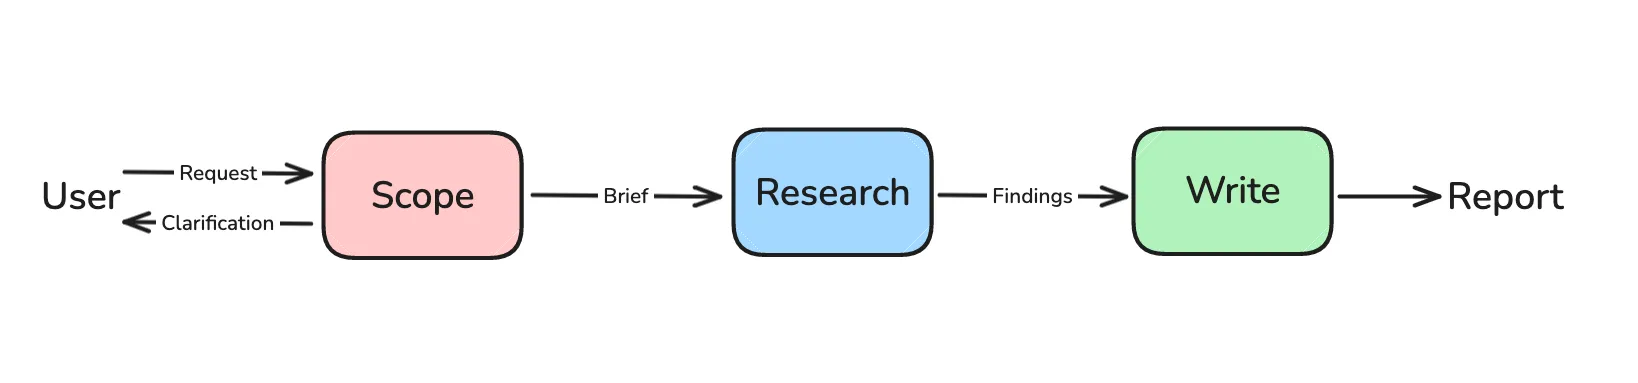

We've built research scoping and multi-agent research in previous notebooks.

Now, we'll add the final report generation step.

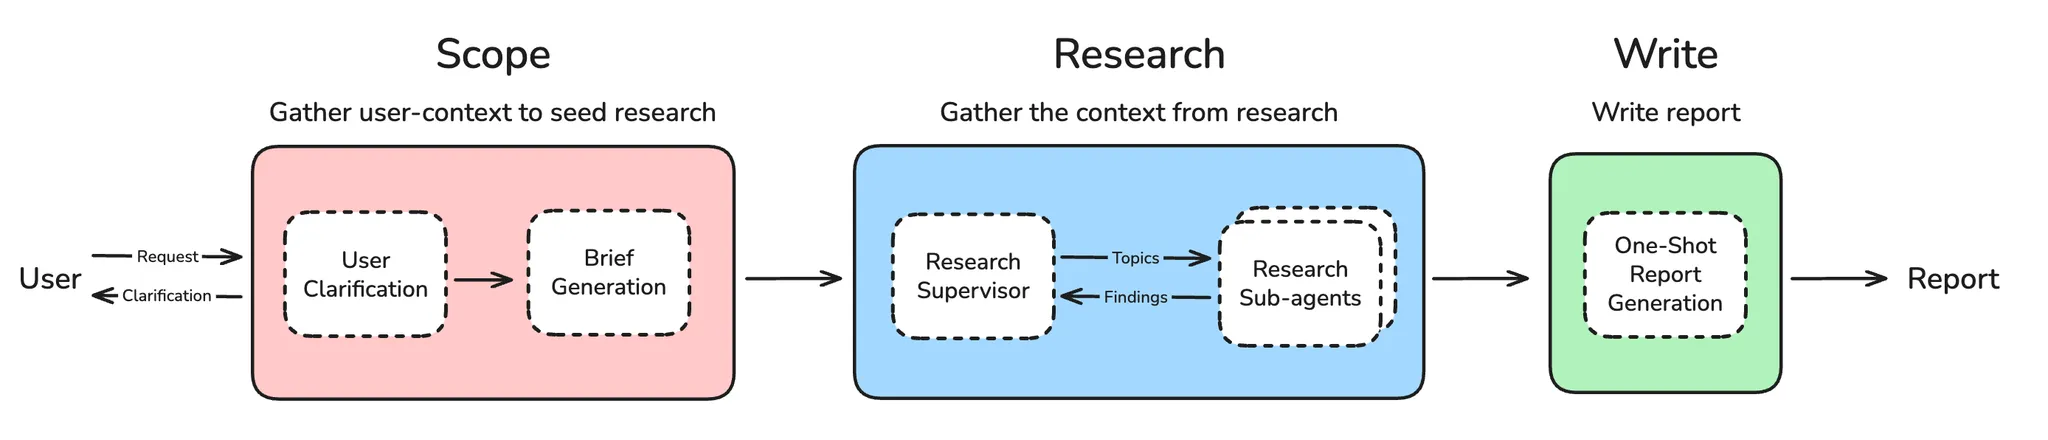

### Agent 

We simply can re-use the components we've already built.

In [2]:
%%writefile ../src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# ===== Config =====

from langchain.chat_models import init_chat_model
writer_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000

# ===== FINAL REPORT GENERATION =====

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== GRAPH CONSTRUCTION =====
# Build the overall workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# Compile the full workflow
agent = deep_researcher_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_full.py


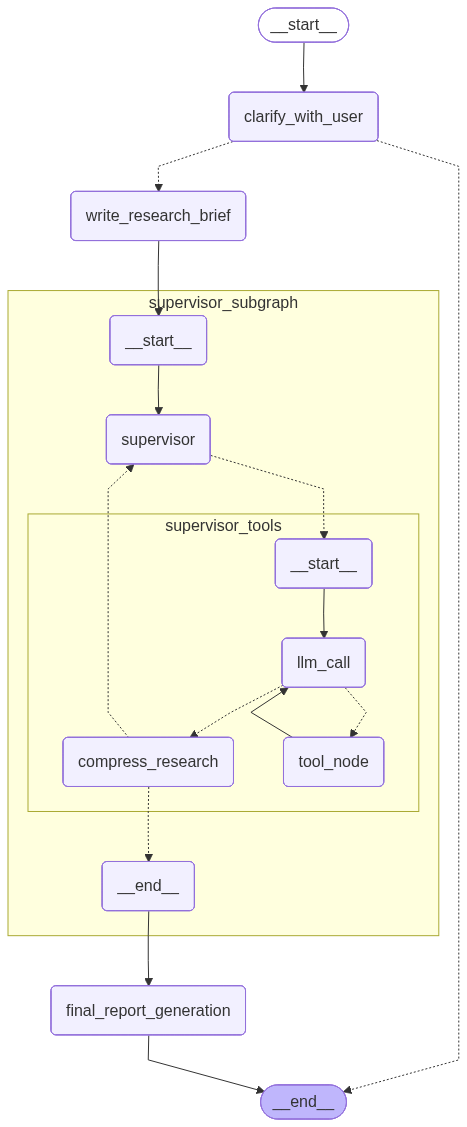

In [4]:
# Run the workflow
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

LangGraph has a default recursion limit of 25 steps to prevent infinite loops. For complex research workflows that require iterative rounds of research, this limit needs to be increased. As explained in [LangGraph's troubleshooting guide](https://langchain-ai.github.io/langgraph/troubleshooting/errors/GRAPH_RECURSION_LIMIT/), the recursion limit counts every node execution in the graph. In our multi-agent research system:

- **Single Research Agent**: May take 8-12 steps for tool calls and compression
- **Multi-Agent Supervisor**: Each sub-agent spawned adds additional steps
- **Iterative Research**: Supervisor may conduct multiple rounds of research to fill gaps
- **Full Workflow**: Includes scoping, research brief generation, supervision, and report generation

We set the recursion limit to **50** to accommodate:
- Complex research topics requiring multiple research rounds
- Parallel sub-agent execution
- Deep research with many tool calls
- Complete workflow execution from scoping to final report

This allows the supervisor to conduct iterative rounds of research when initial findings have gaps, ensuring comprehensive coverage of complex research topics.

In [5]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini to OpenAI Deep Research agents.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify what you mean by 'OpenAI Deep Research agents'? Are you referring to OpenAI's advanced        │
│ research models (like GPT-4 or GPT-5), or specific autonomous research agents/tools developed by OpenAI? Also,  │
│ are you interested in a technical comparison, use cases, or performance benchmarks?                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Yes the specific Deep Research agents/tools/products developed by OpenAI. yes i am interested in a technical comparison")]}, config=thread)

In [7]:
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify what you mean by 'OpenAI Deep Research agents'? Are you referring to OpenAI's advanced        │
│ research models (like GPT-4 or GPT-5), or specific autonomous research agents/tools developed by OpenAI? Also,  │
│ are you interested in a technical comparison, use cases, or performance benchmarks?                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Yes the specific Deep Research agents/tools/products developed by OpenAI. yes i am interested in a technical    │
│ comparison                                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for clarifying. You are requesting a technical comparison between Google's Gemini and the specific    │
│ Deep Research agents/tools/products developed by OpenAI. I will now begin the research and analysis based on    │
│ this scope.                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: # Technical Comparison: Google Gemini vs. OpenAI Deep Research Agents, Tools, and     │
│ Products                                                                                                        │
│                                                                                                                 │
│ ## Introduction                                                                                                 │
│                                                                                                                 │
│ This report provides a comprehensive technical comparison between Google's Gemini AI models and the set of      │
│ advanced research agents, tools, and products from OpenAI that support deep reasoning, analysis, and autonomous │
│ research workflows. The comparison focuses on six key dimensions: architecture, capabilities, performance       │
│ benchmarks, scalability, integration options, and unique features. All conclusions reference official           │
│ documentation, research papers, and reputable product sources up to December 2025.                              │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## Overview of Google Gemini                                                                                    │
│                                                                                                                 │
│ Google Gemini is Google DeepMind’s flagship family of large multimodal AI models, designed for both             │
│ general-purpose and domain-specific applications. The latest release, Gemini 3 (including Pro, Flash, and Deep  │
│ Think variants), demonstrates state-of-the-art reasoning, multimodality, and agentic capabilities. Gemini       │
│ models are natively multimodal—processing text, images, audio, video, and code—and are accessible via Google AI │
│ Studio, Vertex AI on Google Cloud, APIs, and edge devices (Nano).                                               │
│                                                                                                                 │
│ ### Architecture                                                                                                │
│                                                                                                                 │
│ - **Model Family & Sizes:** Gemini encompasses several model versions (Ultra, Pro, Flash, Flash-Lite/2.5        │
│ Flash), each scaled for different latency, throughput, and cost needs. Gemini Ultra 1.0 is reported to have up  │
│ to 1.5 trillion parameters, while Pro/Flash variants are more lightweight for cost or edge applications.        │
│ - **Core Design:** Utilizes a Sparse Mixture-of-Experts (MoE) transformer architecture for efficiency at scale, │
│ enabling expert gating and modular routing through vast parameter spaces[1][2].                                 │
│ - **Multimodality:** Built from the ground up for “native multimodality”—jointly trained on very large-scale,   │
│ integrated datasets spanning multiple modalities rather than via adapters or post-training. This enables more   │
│ robust cross-modal grounding.                                                                                   │
│ - **Context Window:** Gemini 3 supports input contexts up to 1 million tokens and outputs up to 65,535 tokens   │
│ per request (input size up to 500 MB or thousands of images and hours of audio/video). Large context windows    │
│ allow ingestion of entire books or multi-source dataset

In [8]:
from rich.markdown import Markdown
Markdown(result["final_report"])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Technical Comparison: Google Gemini vs. OpenAI Deep Research Agents, Tools, and Products             ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                   Introduction                                                    

This report provides a comprehensive technical comparison between Google's Gemini AI models and the set of advanced
research agents, tools, and products from OpenAI that support deep reasoning, analysis, and autonomous research    
workflows. The comparison focuses on six key dimensions: architecture, capabilities, performance benchmarks,       
scalability, integration options, and unique features. All conclusions reference official documentation, research  
papers, and reputable product sources up to December 2025.                                                         

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                             Overview of Google Gemini                                             

Google Gemini is Google DeepMind’s flagship family of large multimodal AI models, designed for both general-purpose
and domain-specific applications. The latest release, Gemini 3 (including Pro, Flash, and Deep Think variants),    
demonstrates state-of-the-art reasoning, multimodality, and agentic capabilities. Gemini models are natively       
multimodal—processing text, images, audio, video, and code—and are accessible via Google AI Studio, Vertex AI on   
Google Cloud, APIs, and edge devices (Nano).                                                                       

                                                   Architecture                                                    

 • Model Family & Sizes: Gemini encompasses several model versions (Ultra, Pro, Flash, Flash-Lite/2.5 Flash), each 
   scaled for different latency, throughput, and cost needs. Gemini Ultra 1.0 is reported to have up to 1.5        
   trillion parameters, while Pro/Flash variants are more lightweight for cost or edge applications.               
 • Core Design: Utilizes a Sparse Mixture-of-Experts (MoE) transformer architecture for efficiency at scale,       
   enabling expert gating and modular routing through vast parameter spaces[1][2].                                 
 • Multimodality: Built from the ground up for “native multimodality”—jointly trained on very large-scale,         
   integrated datasets spanning multiple modalities rather than via adapters or post-training. This enables more   
   robust cross-modal grounding.                                                                                   
 • Context Window: Gemini 3 supports input contexts up to 1 million tokens and outputs up to 65,535 tokens per     
   request (input size up to 500 MB or thousands of images and hours of audio/video). Large context windows allow  
   ingestion of entire books or multi-source datasets in a single prompt[2][3][4].                                 

                                                   Capabilities                                                    

 • Reasoning & Planning: Gemini 3 Pro exhibits state-of-the-art performance in multi-step reasoning, long-horizon  
   planning, and agentic orchestration—capable of managing multi-step tasks and autonomously planning solutions    
   (e.g., solving scientific problems, complex coding tasks, analysis across documents)[3][4][5].                  
 • Multimodal Understanding: Excels in visual reasoning, video understanding, audio processing, document QA, and   
   code comprehension/execution over broad inputs.                                                                 
 • Specialized Agents: ‘Deep Think’ variant sp

We can see the trace [here](https://smith.langchain.com/public/86ebdc25-4595-4040-be1e-a8e30052786b/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

The files we wrote with `%%writefile` to `src/deep_research_from_scratch/` during the all the notebooks create the files for our application:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State definitions
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt templates
│   └── ...
├── notebooks/            # Development notebooks
├── pyproject.toml        # Dependencies
└── langgraph.json        # LangGraph configuration
```

This agent has been added to the `langgraph.json` file, so you can select `research_agent_full` in the dropdown menu:

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```